In [ ]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Đọc dữ liệu từ file json

In [ ]:
review= pd.read_json(r'review_software.json', lines= True)

In [ ]:
# Lưu dưới dạng file csv 
review.to_csv('review_software.csv')

#### Pre- processing


In [ ]:
review.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN
3,3,True,"02 17, 2014",APRDVZ6QBIQXT,0077613252,{'Format:': ' Loose Leaf'},Lucy,This book was missing pages!!! Important pages...,missing pages!!,1392595200,3,NaN
4,5,False,"10 14, 2013",A2JZTTBSLS1QXV,0077775473,NaN,Albert V.,I have used LearnSmart and can officially say ...,Best study product out there!,1381708800,NaN,NaN


In [ ]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459436 entries, 0 to 459435
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         459436 non-null  int64 
 1   verified        459436 non-null  bool  
 2   reviewTime      459436 non-null  object
 3   reviewerID      459436 non-null  object
 4   asin            459436 non-null  object
 5   style           234401 non-null  object
 6   reviewerName    459412 non-null  object
 7   reviewText      459370 non-null  object
 8   summary         459380 non-null  object
 9   unixReviewTime  459436 non-null  int64 
 10  vote            127853 non-null  object
 11  image           1508 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 39.0+ MB


In [ ]:
review.isna().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             225035
reviewerName          24
reviewText            66
summary               56
unixReviewTime         0
vote              331583
image             457928
dtype: int64

In [ ]:
# Xử lý missing value: Bỏ feature ['image', 'style', 'vote']
review1=review.drop(['image','style','vote'],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
#Chuyển reviewTime về kiểu dữ liệu datetime, verified -> int
import datetime as dt
review1['reviewTime']= pd.to_datetime(review1['reviewTime'])
review1['verified']= review1['verified'].astype(int)

In [ ]:
review1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459436 entries, 0 to 459435
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         459436 non-null  int64         
 1   verified        459436 non-null  int64         
 2   reviewTime      459436 non-null  datetime64[ns]
 3   reviewerID      459436 non-null  object        
 4   asin            459436 non-null  object        
 5   reviewerName    459412 non-null  object        
 6   reviewText      459370 non-null  object        
 7   summary         459380 non-null  object        
 8   unixReviewTime  459436 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 31.5+ MB


In [ ]:
review1.head(3)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime
0,4,1,2014-03-11,A240ORQ2LF9LUI,0077613252,Michelle W,The materials arrived early and were in excell...,Material Great,1394496000
1,4,1,2014-02-23,A1YCCU0YRLS0FE,0077613252,Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600
2,1,1,2014-02-17,A1BJHRQDYVAY2J,0077613252,Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200


##### Phân phối của overall trong tập dữ liệu

In [ ]:
rating= review['overall'].value_counts()*100/len(review['overall'])
rating

5    46.241914
1    22.320410
4    16.018771
3     8.574644
2     6.844261
Name: overall, dtype: float64

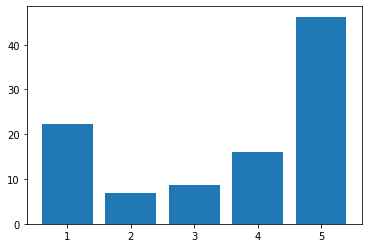

In [ ]:
plt.bar(rating.index, rating);

In [ ]:
df= review1[['reviewText','overall']]

Nhận xét: Các đánh giá tập trung nhiều nhất ở mức 5 với 46.24% và tiếp đến là các đánh giá ở mức 1 với 22.32%

Nếu quy ước với mức độ đánh giá từ mức 3 trở lên là khách hàng tương đối hài lòng đến rất hài lòng về sản phẩm thì hiện tại chiếm khoảng $84.68\%$ trong tổng số đánh giá cho thấy  là các sản phẩm phần mềm hiện tại đáp ứng phần nào nhu cầu của khách hàng tuy nhiên số lượng đánh giá mức 1 đang khá cao do vậy cần tìm hiểu vấn đề từ những đánh giá đó để đưa ra giải pháp khắc phục.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459436 entries, 0 to 459435
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewText  459370 non-null  object
 1   overall     459436 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB


In [ ]:
# Xoá các hàng có missing value
df1=df.dropna()
df1.head()

,reviewText,overall
0,The materials arrived early and were in excell...,4
1,I am really enjoying this book with the worksh...,4
2,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",1
3,This book was missing pages!!! Important pages...,3
4,I have used LearnSmart and can officially say ...,5


In [ ]:
stop_words= set(stopwords.words('english'))
print(stop_words)

{'you', "isn't", 'we', 'whom', 'by', 'weren', "couldn't", 'there', 'when', "mustn't", 'theirs', 'about', "wasn't", 'will', 'o', 'her', 'doing', 'above', 'than', 'ma', 'having', 'and', 'through', 'mightn', "it's", 'how', 'or', 'during', 'for', 'an', 'your', 'off', 'now', 't', 'i', 'both', "shan't", 'wasn', 'up', 'here', 'into', "doesn't", 's', 'yours', 'further', 'll', 'isn', 'that', 'myself', 'themselves', 'too', "you'll", 'should', 'of', 'won', 'under', 'am', 'mustn', 'any', 'can', 'such', "shouldn't", 'but', 'where', 'couldn', "should've", 'these', 'from', 'in', 'other', 'wouldn', 'yourself', 'while', "wouldn't", 'is', 'they', 'y', 'me', 'very', "you've", "hadn't", "needn't", 'being', 've', 'didn', 'more', "mightn't", 'once', 'shouldn', 'as', 'did', 'their', 'only', 'haven', 'them', 'him', "won't", 'been', "she's", 'he', 'no', 'does', 'the', 'before', 'so', "that'll", 'over', "hasn't", 'who', 'hers', 'against', 'just', 'own', 'do', 'ain', 'shan', 'with', 'why', 'below', 'this', 'betw

#### Hàm làm sạch text:
+ Chuyển về ký tự thường
+ Loại bỏ các ký tự dấu câu
+ Loại bỏ các ký tự không phải chữ
+ Loại bỏ các ký tự, chữ cái đứng 1 mình
+ Loại bỏ các từ stopword
+ Đưa các từ trong text về dạng từ gốc

In [ ]:
import string
from nltk.stem import WordNetLemmatizer
lemmatizer= WordNetLemmatizer()
def clean_text(review):
    review= str(review).lower() #chuyển tất cả về chữ thường
    review= review.split()
    table= str.maketrans('','', string.punctuation) # loại bỏ dấu câu
    review= [w.translate(table) for w in review]
    review= [word for word in review if word.isalpha()] # loại bỏ các ký tự không phải chữ cái
    review=[w for w  in review if not w in stop_words] # Loại bỏ các stop word
    review= [word for word in review if len(word)>1] # loại bỏ ký tự đứng 1 mình
    review= [lemmatizer.lemmatize(w) for w in review]
    return review

In [ ]:
df1['review']= df1['reviewText'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1['review']= df1['review'].apply(lambda x:' '.join(i for i in x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1.head()

,reviewText,overall,review
0,The materials arrived early and were in excell...,4,material arrived early excellent condition how...
1,I am really enjoying this book with the worksh...,4,really enjoying book worksheet make review goa...
2,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",1,taking class dont waste money called book book...
3,This book was missing pages!!! Important pages...,3,book missing page important page couldnt answe...
4,I have used LearnSmart and can officially say ...,5,used learnsmart officially say amazing study t...


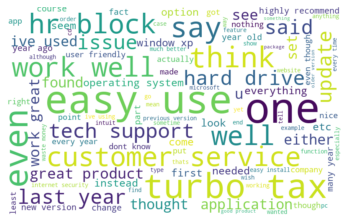

In [ ]:
txt= ' '.join(review for review in df1['review'])
wordcloud= WordCloud(background_color= 'white', max_font_size= 100, 
                     max_words= 100, width= 800, height= 500).generate(txt)
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis

In [ ]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459436 entries, 0 to 459435
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         459436 non-null  int64  
 1   verified        459436 non-null  bool   
 2   reviewTime      459436 non-null  object 
 3   reviewerID      459436 non-null  object 
 4   asin            459436 non-null  object 
 5   style           234401 non-null  object 
 6   reviewerName    459412 non-null  object 
 7   reviewText      459370 non-null  object 
 8   summary         459380 non-null  object 
 9   unixReviewTime  459436 non-null  int64  
 10  vote            127853 non-null  object 
 11  image           1508 non-null    object 
 12  rating_count    0 non-null       float64
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 42.5+ MB


In [ ]:
rating_count= review.groupby(by='asin').agg({'overall':'count'})
rating_count.rename(columns= {'overall':'numReview'}, inplace= True)

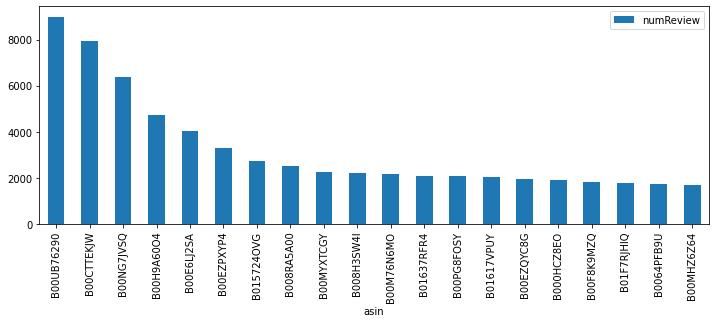

In [ ]:
popular_product= rating_count.sort_values('numReview',ascending= False)
popular_product.head(20).plot(kind="bar", figsize= (12,4))

###Predict overall based on review text

#### Chia tập dữ liệu thành tập train và test

In [ ]:
X=df1['review']
y= df1['overall']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state=42)

#### Chuẩn hoá các review thành các vector có độ dài d là độ dài của bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer= CountVectorizer()
vectorizer.fit(X_train)
X_train1= vectorizer.transform(X_train)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer= TfidfTransformer()
tfidf_transformer.fit(X_train1)
tfidf_transformer.transform(X_train1)

<367496x155941 sparse matrix of type '<class 'numpy.float64'>'
	with 11372478 stored elements in Compressed Sparse Row format>

In [ ]:
X_test= vectorizer.transform(X_test)

#### Sử dụng mô hình Multinomial Naivie Bayes dự đoán

In [ ]:
from sklearn.naive_bayes import MultinomialNB
NB= MultinomialNB()
NB.fit(X_train1, y_train)

MultinomialNB()

In [ ]:
pred= NB.predict(X_test)

In [ ]:
pred

array([5, 1, 5, ..., 1, 5, 4])

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.61      0.80      0.69     20326
           2       0.25      0.03      0.06      6232
           3       0.32      0.08      0.13      7891
           4       0.38      0.21      0.27     14585
           5       0.70      0.88      0.78     42840

    accuracy                           0.63     91874
   macro avg       0.45      0.40      0.38     91874
weighted avg       0.56      0.63      0.57     91874



In [ ]:
print(confusion_matrix(y_test, pred))

[[16283   288   434   624  2697]
 [ 3327   195   381   744  1585]
 [ 2598   145   644  1499  3005]
 [ 1922    98   362  3014  9189]
 [ 2714    46   164  2032 37884]]
